In [170]:
import kagglehub
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [171]:
# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/fedesoriano/heart-failure-prediction/versions/1


In [172]:
os.listdir(path)

['heart.csv']

In [234]:
# Assuming the CSV file is named `heart_failure_clinical_records_dataset.csv`
csv_file_path = os.path.join(path, 'heart.csv')

# Load the CSV file into a pandas DataFrame
heart_fail_df = pd.read_csv(csv_file_path)

In [235]:
"""Exploratory Data Analysis (EDA)"""

'Exploratory Data Analysis (EDA)'

In [236]:
"""
Looking at columns. Description below sourced from Kaggle

Attribute Information
Age: age of the patient [years]
Sex: sex of the patient [M: Male, F: Female]
ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]
FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
HeartDisease: output class [1: heart disease, 0: Normal]
"""
heart_fail_df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [237]:
heart_fail_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [238]:
heart_fail_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [239]:
hf_df_encoded = pd.get_dummies(heart_fail_df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

/tmp/ipykernel_27908/1394832333.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='HeartDisease', data=hf_df_encoded, palette='viridis')


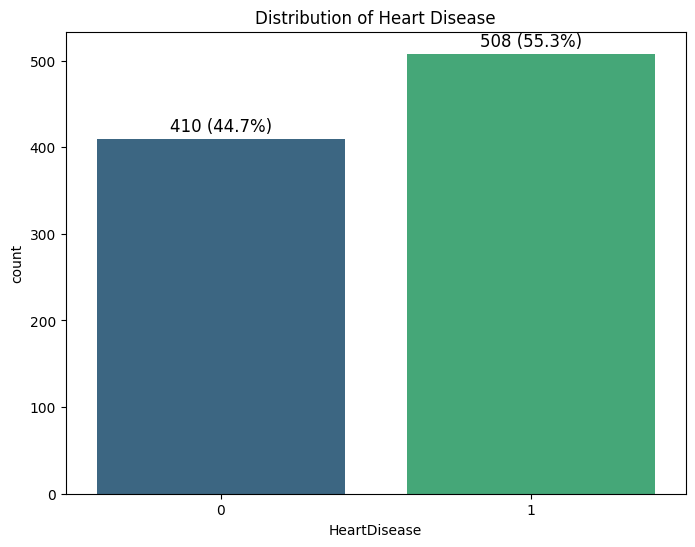

In [240]:
# Plot target variable distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='HeartDisease', data=hf_df_encoded, palette='viridis')
plt.title("Distribution of Heart Disease")

# Calculate total number of observations
total_count = len(hf_df_encoded)

# Add counts and percentages above each bar
for p in ax.patches:
    count = int(p.get_height())  # Get count for each bar
    percentage = 100 * count / total_count  # Calculate percentage
    ax.annotate(f'{count} ({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

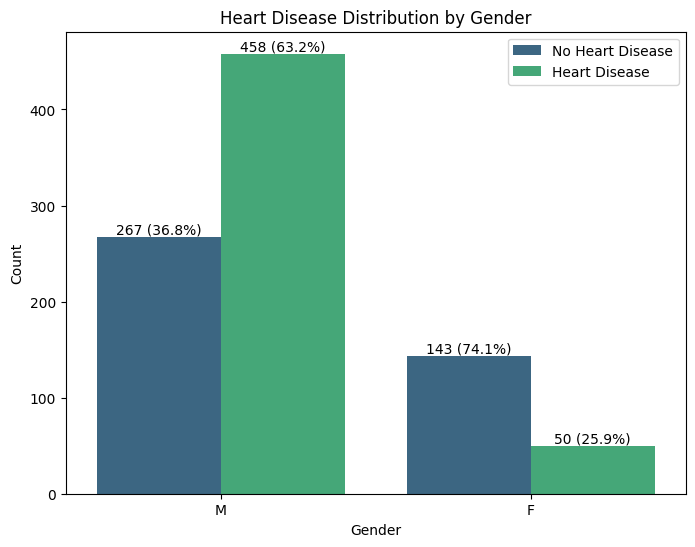

In [241]:
# Plot distribution of HeartDisease by gender
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Sex', hue='HeartDisease', data=heart_fail_df, palette='viridis')
plt.title('Heart Disease Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='', labels=['No Heart Disease', 'Heart Disease'])

# Calculate totals and percentages for each category and gender
totals = heart_fail_df['Sex'].value_counts()

# Add counts and percentages above each bar
for pitr, p in enumerate(ax.patches):
    count = int(p.get_height())
    # Retrieve the gender label
    if np.mod(pitr, 2) == 0:
        gender = 'M'
    else:
        gender = 'F'
    percentage = (count / totals[gender]) * 100  # calculate percentage based on gender totals
    # Add text above bar
    if count > 0:  # Avoid displaying '0 (0.0%)'
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', 
                    va = 'bottom')

plt.show()

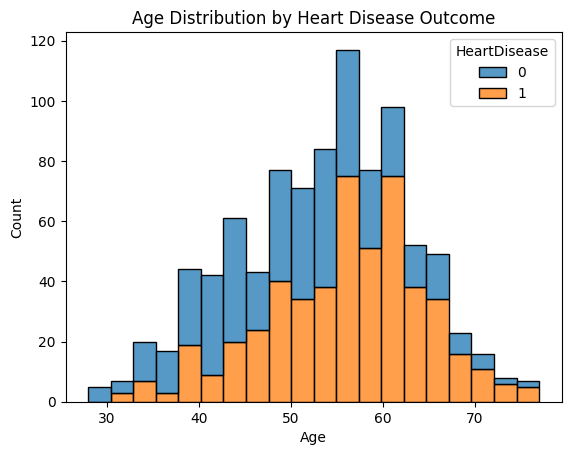

In [242]:
# EDA: Age distribution by heart disease outcome
sns.histplot(data=heart_fail_df, x='Age', hue='HeartDisease', multiple='stack', bins=20)
plt.title("Age Distribution by Heart Disease Outcome")
plt.show()

In [243]:
# Visualize the distribution of heart disease by age in a table format 
# Define age bins and labels for each range
age_bins = np.linspace(heart_fail_df['Age'].min(), heart_fail_df['Age'].max(), 11)  # Divide age range into 10 bins
age_labels = [f"{int(age_bins[i])} - {int(age_bins[i+1])}" for i in range(len(age_bins)-1)]

hfd_copy = heart_fail_df.copy()
# Bin the data by age
hfd_copy['AgeRange'] = pd.cut(heart_fail_df['Age'], bins=age_bins, labels=age_labels, right=False)

# Group by age range and heart disease status to get counts
age_grouped = hfd_copy.groupby(['AgeRange', 'HeartDisease']).size().unstack(fill_value=0)

# Rename columns for clarity
age_grouped.columns = ['Without Heart Disease', 'With Heart Disease']

# Calculate total counts and percentages
age_grouped['Total'] = age_grouped['Without Heart Disease'] + age_grouped['With Heart Disease']
age_grouped['% With Heart Disease'] = (age_grouped['With Heart Disease'] / age_grouped['Total'] * 100).round(1)
age_grouped['% Without Heart Disease'] = (age_grouped['Without Heart Disease'] / age_grouped['Total'] * 100).round(1)

# Display the final table
age_grouped = age_grouped[['Total', 'With Heart Disease', 'Without Heart Disease', '% With Heart Disease', '% Without Heart Disease']]
print(age_grouped)


          Total  With Heart Disease  Without Heart Disease  \
AgeRange                                                     
28 - 32      12                   3                      9   
32 - 37      37                  10                     27   
37 - 42      86                  28                     58   
42 - 47     104                  44                     60   
47 - 52     148                  74                     74   
52 - 57     201                 113                     88   
57 - 62     175                 126                     49   
62 - 67     101                  72                     29   
67 - 72      39                  27                     12   
72 - 77      13                   9                      4   

          % With Heart Disease  % Without Heart Disease  
AgeRange                                                 
28 - 32                   25.0                     75.0  
32 - 37                   27.0                     73.0  
37 - 42                

/tmp/ipykernel_27908/4055459557.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_grouped = hfd_copy.groupby(['AgeRange', 'HeartDisease']).size().unstack(fill_value=0)


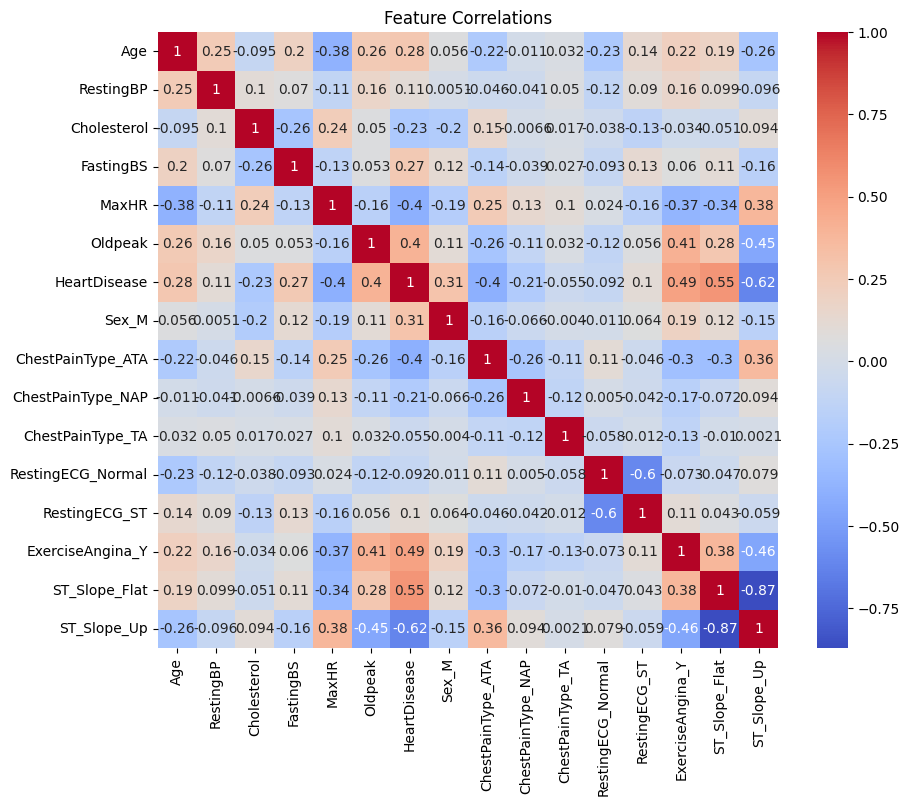

In [244]:
# Looking at feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(hf_df_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

In [245]:
heart_fail = heart_fail_df[heart_fail_df['HeartDisease']==1]
no_heart_fail = heart_fail_df[heart_fail_df['HeartDisease']==0]

hf_mean = heart_fail['MaxHR'].mean().round(2)
nhf_mean = no_heart_fail['MaxHR'].mean().round(2)
hf_std = heart_fail['MaxHR'].std().round(3)
nhf_std = no_heart_fail['MaxHR'].std().round(3)
print(f"Heart failure cohort mean, stdev: ({hf_mean}, {hf_std})\nHealthy control cohort mean, stdev: ({nhf_mean}, {nhf_std})")

Heart failure cohort mean, stdev: (127.66, 23.387)
Healthy control cohort mean, stdev: (148.15, 23.288)


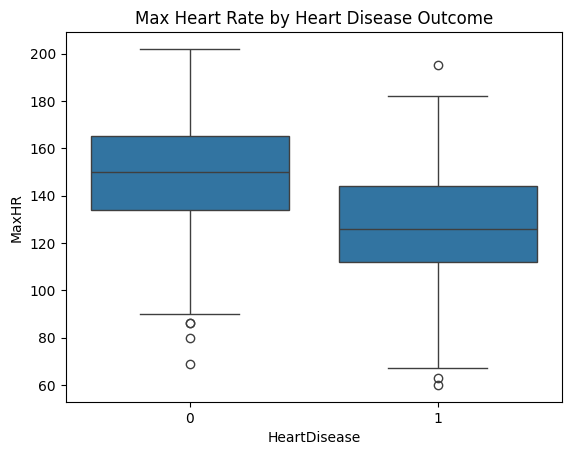

In [246]:
# EDA: Boxplot for Cholesterol levels by heart disease outcome
sns.boxplot(x='HeartDisease', y='MaxHR', data=heart_fail_df)
plt.title("Max Heart Rate by Heart Disease Outcome")
plt.show()

In [247]:
"""Feature Engineering"""

'Feature Engineering'

In [248]:
# Create an interaction feature combining RestingBP and Cholesterol
heart_fail_df['BP_Cholesterol'] = heart_fail_df['RestingBP'] * heart_fail_df['Cholesterol']

In [249]:
# Selecting continuous features to apply polynomial transformation on
# You can adjust this list based on the specific columns you'd like to transform
cts_cols = ['Age', 'MaxHR', 'Oldpeak', 'Log_RestingBP', 'Log_Cholesterol']
non_cts_cols = [col for col in heart_fail_df.columns if col not in cts_cols]
continuous_features = heart_fail_df[cts_cols]

# Initialize PolynomialFeatures with the desired degree
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform the data
poly_features = poly.fit_transform(continuous_features)

# Convert the polynomial features into a DataFrame with meaningful column names
poly_feature_names = poly.get_feature_names_out(continuous_features.columns)
heart_fail_df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

# Concatenate the original DataFrame with the new polynomial features
heart_fail_df = pd.concat([heart_fail_df[non_cts_cols], heart_fail_df_poly], axis=1)

KeyError: "['Log_RestingBP', 'Log_Cholesterol'] not in index"

In [ ]:
# One-hot encoding for categorical features
heart_fail_df_ohe = pd.get_dummies(heart_fail_df, columns=['Sex','ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], 
                                   drop_first=True)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
heart_fail_df_ohe[numerical_features] = scaler.fit_transform(heart_fail_df_ohe[numerical_features])

In [ ]:
# # Standardize numerical features
# scaler = StandardScaler()
# numerical_features = ['BP_Cholesterol', 'Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Age^2',
#                       'Age MaxHR', 'Age Oldpeak', 'MaxHR^2', 'MaxHR Oldpeak', 'Oldpeak^2']
# heart_fail_df_ohe[numerical_features] = scaler.fit_transform(heart_fail_df_ohe[numerical_features])

In [ ]:
"""Using XGBoost to predict heart failure"""

In [ ]:
# Split data into features and target
X = heart_fail_df_ohe.drop('HeartDisease', axis=1)
y = heart_fail_df_ohe['HeartDisease']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", auc)

# Display classification report for additional metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference (random guessing)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
"""Looking to improve model by optimizing parameters"""

In [252]:
from sklearn.model_selection import RandomizedSearchCV
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [100*n for n in range(1,11)],
    'max_depth': [n for n in range(1, 12)],
    'learning_rate': [0.01, 0.03, 0.05, 0.75, 0.1],
    'min_child_weight': [1, 2, 3, 4, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
random_search = RandomizedSearchCV(model, param_grid, scoring='roc_auc', n_iter=10, cv=3, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/ec2-user/anaconda3/envs/sepsis_env/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/sepsis_env/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Parameters: {'subsample': 1.0, 'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [253]:
# Replace these with the best parameters from RandomizedSearchCV or GridSearchCV
best_params = random_search.best_params_  # Get the best parameters from the search

# Initialize the model with the optimal parameters
optimized_model = XGBClassifier(**best_params)

# Re-train on the entire training set
optimized_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.8641304347826086
ROC-AUC Score: 0.9380992838936764

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.89      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



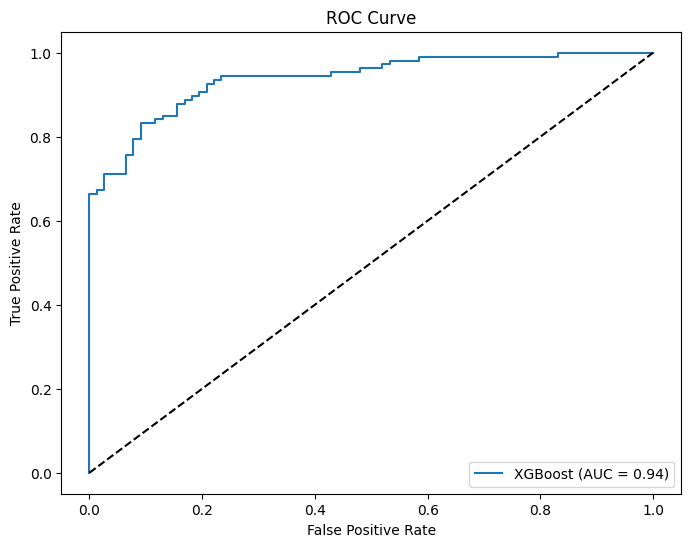

In [254]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Make predictions on the test set
y_pred = optimized_model.predict(X_test)
y_pred_proba = optimized_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", auc)

# Display classification report for additional metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference (random guessing)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


ROC-AUC Score: 0.9380992838936764


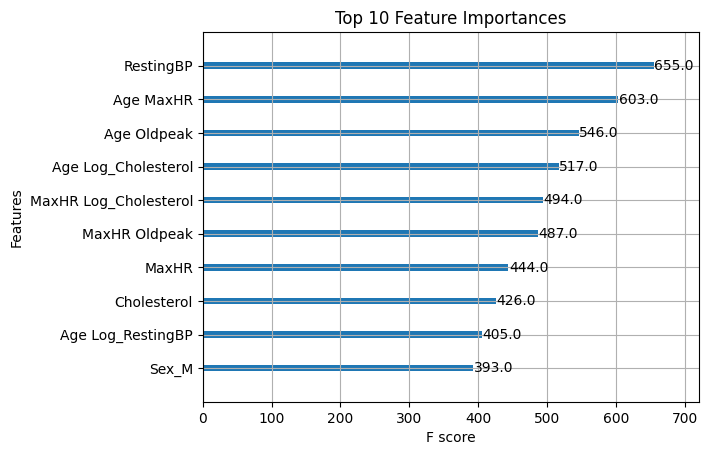

In [255]:
from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC
auc = roc_auc_score(y_test, optimized_model.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", auc)

# Feature importance
import xgboost as xgb
xgb.plot_importance(optimized_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()
